In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


# DenseNet201 Fine Tuning

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', test_size=0.1)

In [4]:
model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()

In [5]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 97s - loss: 1.1625 - acc: 0.5436 - val_loss: 0.7012 - val_acc: 0.7258

Epoch 00001: val_loss improved from inf to 0.70120, saving model to ./DenseNet201-Fine-Tune.h5
Epoch 2/100
 - 57s - loss: 0.6406 - acc: 0.7727 - val_loss: 0.5781 - val_acc: 0.7859

Epoch 00002: val_loss improved from 0.70120 to 0.57808, saving model to ./DenseNet201-Fine-Tune.h5
Epoch 3/100
 - 58s - loss: 0.5110 - acc: 0.8212 - val_loss: 0.5057 - val_acc: 0.8120

Epoch 00003: val_loss improved from 0.57808 to 0.50567, saving model to ./DenseNet201-Fine-Tune.h5
Epoch 4/100
 - 57s - loss: 0.4087 - acc: 0.8590 - val_loss: 0.4898 - val_acc: 0.8277

Epoch 00004: val_loss improved from 0.50567 to 0.48984, saving model to ./DenseNet201-Fine-Tune.h5
Epoch 5/100
 - 57s - loss: 0.3648 - acc: 0.8701 - val_loss: 0.4195 - val_acc: 0.8721

Epoch 00005: val_loss improved from 0.48984 to 0.41952, saving model to ./DenseNet201-Fine-Tune.h5
Epoch 6/100
 - 57s - loss: 0.3138 - acc: 0.8890 - val_loss: 0.4192 - val_acc: 0

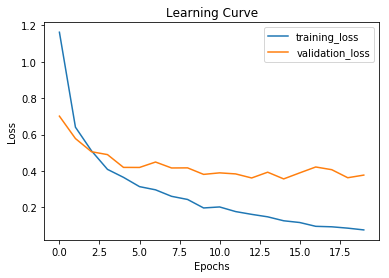

In [6]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

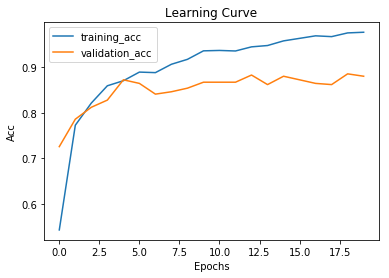

In [7]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import load_model, Model
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=224)

model_name = 'DenseNet201-Fine-Tune'
model_path = './{}.h5'.format(model_name)
model = load_model(model_path)
y_test_pred_prob = model.predict(X_test)

#y_test_pred = y_test_pred_prob.argmax(axis=-1)
#y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred_prob}).sort_values(by='id')
#y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

'''
scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

'''

Using TensorFlow backend.


"\nscores = model.evaluate(X_valid, y_valid, verbose=1)\nprint('Validation loss:', scores[0])\nprint('Validation accuracy:', scores[1])\n\n"

In [2]:
y_test_pred_id = pd.DataFrame({'id': np.array(X_id)})
y_test_pred_arr = pd.DataFrame(y_test_pred_prob)
y_test_pred_id.to_csv("./{}_prob.csv".format(model_name), index=False)
y_test_pred_arr.to_csv("./{}_id.csv".format(model_name), index=False)
